In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_decision_regions



#from sklearn.metrics import plot_confusion_matrix

In [2]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [3]:
#REMOVED AMOUNT. ADD BACK
features = df[["type", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]]
#features = df[[ "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]]

features = pd.get_dummies(features)
features

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.00,160296.36,0.00,0.00,False,False,False,True,False
1,1864.28,21249.00,19384.72,0.00,0.00,False,False,False,True,False
2,181.00,181.00,0.00,0.00,0.00,False,False,False,False,True
3,181.00,181.00,0.00,21182.00,0.00,False,True,False,False,False
4,11668.14,41554.00,29885.86,0.00,0.00,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...
6362615,339682.13,339682.13,0.00,0.00,339682.13,False,True,False,False,False
6362616,6311409.28,6311409.28,0.00,0.00,0.00,False,False,False,False,True
6362617,6311409.28,6311409.28,0.00,68488.84,6379898.11,False,True,False,False,False
6362618,850002.52,850002.52,0.00,0.00,0.00,False,False,False,False,True


In [4]:
targets = df[["isFraud"]]
targets

,isFraud
0,0
1,0
2,1
3,1
4,0
...,...
6362615,1
6362616,1
6362617,1
6362618,1


In [5]:
#No null values in feature matrix
features.isnull().values.any()

False

In [6]:
#Check variance (important for latter analysis with PCA)

variance = features.var()
print("Variance: \n" + str(variance) + "\n")

"""
mean = features.mean()
print("Mean: \n" + str(mean) + "\n")
"""

mean = features.median()
print("Median: \n" + str(mean) + "\n")


print(features.describe())

Variance: 
amount            3.646448e+11
oldbalanceOrg     8.341946e+12
newbalanceOrig    8.550060e+12
oldbalanceDest    1.155443e+13
newbalanceDest    1.349922e+13
type_CASH_IN      1.715567e-01
type_CASH_OUT     2.279963e-01
type_DEBIT        6.469381e-03
type_PAYMENT      2.238033e-01
type_TRANSFER     7.674113e-02
dtype: float64

Median: 
amount             74871.940
oldbalanceOrg      14208.000
newbalanceOrig         0.000
oldbalanceDest    132705.665
newbalanceDest    214661.440
type_CASH_IN           0.000
type_CASH_OUT          0.000
type_DEBIT             0.000
type_PAYMENT           0.000
type_TRANSFER          0.000
dtype: float64

             amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
count  6.362620e+06   6.362620e+06    6.362620e+06    6.362620e+06   
mean   1.798619e+05   8.338831e+05    8.551137e+05    1.100702e+06   
std    6.038582e+05   2.888243e+06    2.924049e+06    3.399180e+06   
min    0.000000e+00   0.000000e+00    0.000000e+00    0.000000e+00  

In [7]:
#Scale features

gauss_scale = StandardScaler()
standard_features = gauss_scale.fit_transform(features)
standard_features


array([[-2.81559923e-01, -2.29810037e-01, -2.37621696e-01, ...,
        -8.09596451e-02,  1.39903602e+00, -3.02345156e-01],
       [-2.94767262e-01, -2.81359380e-01, -2.85812295e-01, ...,
        -8.09596451e-02,  1.39903602e+00, -3.02345156e-01],
       [-2.97554804e-01, -2.88653782e-01, -2.92441707e-01, ...,
        -8.09596451e-02, -7.14777880e-01,  3.30747816e+00],
       ...,
       [ 1.01539526e+01,  1.89649113e+00, -2.92441707e-01, ...,
        -8.09596451e-02, -7.14777880e-01, -3.02345156e-01],
       [ 1.10976490e+00,  5.58104668e-03, -2.92441707e-01, ...,
        -8.09596451e-02, -7.14777880e-01,  3.30747816e+00],
       [ 1.10976490e+00,  5.58104668e-03, -2.92441707e-01, ...,
        -8.09596451e-02, -7.14777880e-01, -3.02345156e-01]])

In [8]:
subset_percentage = int(len(features)*0.01)

features_subset = features.tail(subset_percentage)
features_subset

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
6298994,53200.17,0.00,53200.17,2381499.31,2328299.13,True,False,False,False,False
6298995,38257.57,53200.17,91457.74,510116.34,471858.78,True,False,False,False,False
6298996,74050.50,91457.74,165508.24,104428.75,30378.25,True,False,False,False,False
6298997,233505.58,165508.24,399013.82,3262077.95,3028572.37,True,False,False,False,False
6298998,297184.11,399013.82,696197.93,693946.59,396762.48,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
6362615,339682.13,339682.13,0.00,0.00,339682.13,False,True,False,False,False
6362616,6311409.28,6311409.28,0.00,0.00,0.00,False,False,False,False,True
6362617,6311409.28,6311409.28,0.00,68488.84,6379898.11,False,True,False,False,False
6362618,850002.52,850002.52,0.00,0.00,0.00,False,False,False,False,True


In [22]:
targets_small = targets.head(subset_percentage)
#filtered_series = targets_small[targets_small == 1].dropna()
targets_small

,isFraud
0,0
1,0
2,1
3,1
4,0
...,...
63621,0
63622,0
63623,0
63624,0


In [34]:
num_fraud = targets_small[targets_small == 1].dropna()
num_fraud
percent_fraud = num_fraud.count() / targets_small.count()
percent_fraud

isFraud    0.00165
dtype: float64

In [10]:
gauss_scale = StandardScaler()

features_scaled = gauss_scale.fit_transform(features_subset)
features_scaled

array([[-0.24303816, -0.30027362, -0.27719444, ..., -0.09389144,
        -0.70381695, -0.32913787],
       [-0.27295375, -0.27309133, -0.25748922, ..., -0.09389144,
        -0.70381695, -0.32913787],
       [-0.20129511, -0.25354386, -0.21934822, ..., -0.09389144,
        -0.70381695, -0.32913787],
       ...,
       [12.28610544,  2.92450169, -0.30459611, ..., -0.09389144,
        -0.70381695, -0.32913787],
       [ 1.35218675,  0.13402988, -0.30459611, ..., -0.09389144,
        -0.70381695,  3.03824049],
       [ 1.35218675,  0.13402988, -0.30459611, ..., -0.09389144,
        -0.70381695, -0.32913787]])

In [11]:
def visualize_pca(pca, pca_result):
    
    # Plot explained variance ratio
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, num_components + 1), pca.explained_variance_ratio_, alpha=0.5, align='center')
    plt.step(range(1, num_components + 1), np.cumsum(pca.explained_variance_ratio_), where='mid')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio by Number of Principal Components')
    plt.xticks(range(1, num_components + 1))
    plt.show()
    
    # Plot 2D or 3D scatter plot based on number of components
    if num_components == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title('2D PCA Visualization')
        plt.show()
    elif num_components == 3:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], alpha=0.5)
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')
        ax.set_title('3D PCA Visualization')
        plt.show()
    else:
        print("Can only visualize 2D or 3D PCA results.")


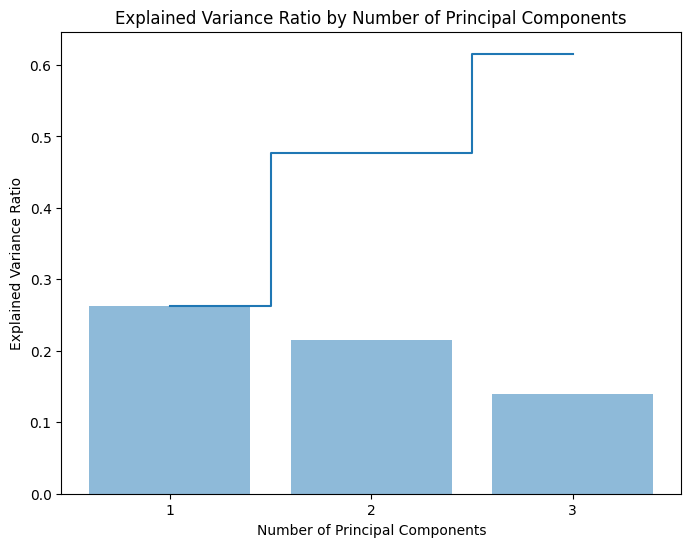

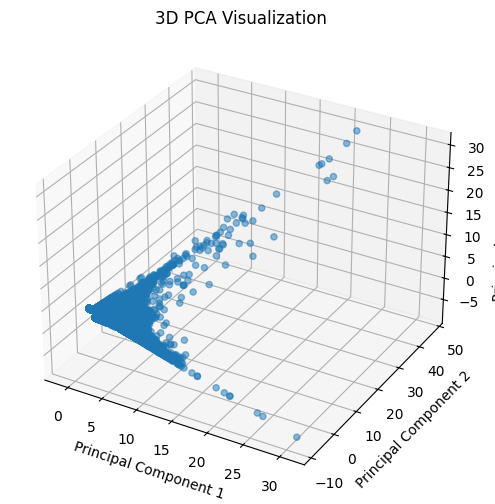

In [12]:
num_components = 3

pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(features_scaled)

visualize_pca(pca, pca_result)

In [13]:
type(pca_result)
print(pca_result)

[[ 0.88814329 -0.05475937  0.33546533]
 [ 0.66994662 -0.58275782  0.02593873]
 [ 0.6569169  -0.69959509 -0.06587695]
 ...
 [ 3.22380758  2.95032711 -4.21198427]
 [ 0.07215523  0.7095465  -0.62132587]
 [ 0.62213834  2.52868541 -0.63690233]]


[0.26231503 0.47684753 0.61573557 0.75231486 0.85360678 0.9364032
 0.99895677 0.99984    1.         1.        ]


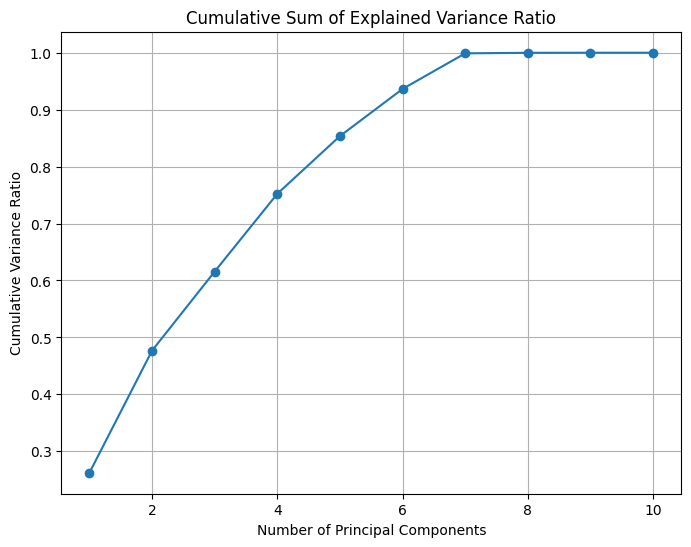

In [14]:
def plot_cumulative_variance(features):
    pca = PCA()
    pca.fit(features)

    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    print(cumulative_variance_ratio)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance Ratio')
    plt.title('Cumulative Sum of Explained Variance Ratio')
    plt.grid(True)
    plt.show()

# Call the function with your scaled feature matrix
plot_cumulative_variance(features_scaled)

In [15]:
targets_small = targets_small.values


X_train, X_test, y_train, y_test = train_test_split(features_scaled, targets_small, test_size=0.33, random_state=42)

num_components = 2
pca = PCA(n_components=num_components)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

principal_components = pca.components_
principal_components

array([[ 0.14786079,  0.54003053,  0.54283103,  0.23919902,  0.23384684,
         0.43541863, -0.12733825, -0.00649749, -0.27153661,  0.01895801],
       [ 0.18674279, -0.22308439, -0.24105199,  0.54682853,  0.56845643,
        -0.18216356,  0.29288203,  0.04338665, -0.26879552,  0.20492287]])

In [45]:
class_weights = {0: 1, 1: 1000}  

clf = SVC(class_weight=class_weights)
clf = SVC(kernel='linear')

In [46]:
clf.fit(X_train_pca, y_train.ravel())

SVC(kernel='linear')

In [47]:
y_pred = clf.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9982378435014526

Accuracy: 0.9982378435014526
Confusion Matrix:
 [[20960     0]
 [   37     0]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     20960
           1       0.00      0.00      0.00        37

    accuracy                           1.00     20997
   macro avg       0.50      0.50      0.50     20997
weighted avg       1.00      1.00      1.00     20997



c:\users\isaak\desktop\csm_files\spring_2024\ml\final_project\employee_counts\env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\isaak\desktop\csm_files\spring_2024\ml\final_project\employee_counts\env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\isaak\desktop\csm_files\spring_2024\ml\final_project\employee_counts\env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

<Figure size 640x480 with 0 Axes>

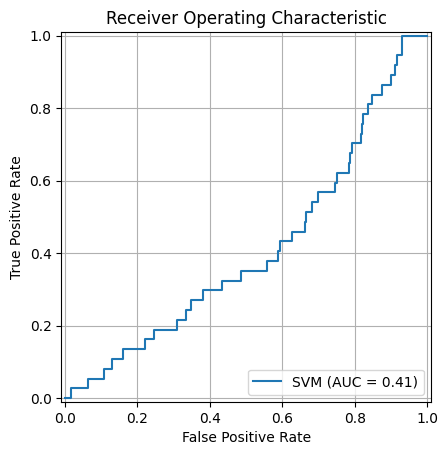

AUC Score: 0.41144393439240773


In [48]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assuming clf, X_test_pca, and y_test are predefined and clf has been fitted

# Predictions
y_pred = clf.predict(X_test_pca)

# Basic accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Precision, Recall, F1-Score
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC Curve and AUC
# Note: roc_curve and auc are applicable for binary classification tasks
if len(np.unique(y_test)) == 2:  # Check if the task is binary
    fpr, tpr, thresholds = roc_curve(y_test, clf.decision_function(X_test_pca))
    roc_auc = auc(fpr, tpr)

    # Plotting ROC Curve
    plt.figure()
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='SVM').plot()
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()
    print("AUC Score:", roc_auc)
else:
    print("ROC and AUC are typically used for binary classification tasks.")


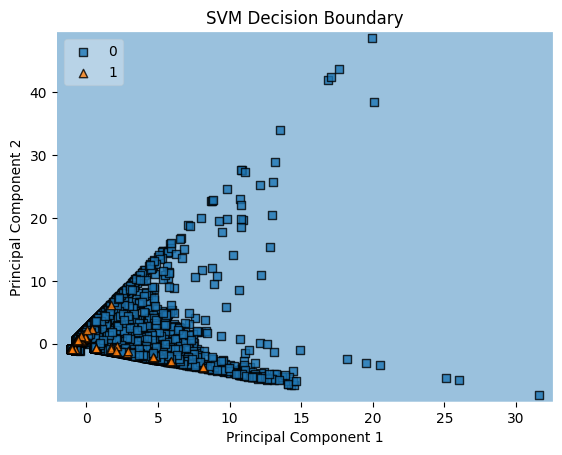

In [44]:
plot_decision_regions(X_train_pca, np.ravel(y_train), clf=clf, legend=2)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM Decision Boundary')
plt.show()

In [ ]:
cols = data.columns
cols


In [ ]:
query = """
        SELECT MAX(amount), MIN(amount) FROM data
        """


In [ ]:
df = sqldf(query)
df

In [ ]:

df['areaname_numeric'] = pd.factorize(df['areaname'])[0]
df['income'] = pd.to_numeric(df['income'])

# Drop the original categorical column if needed
#df = df.drop('areaname', axis=1)

# Display the resulting DataFrame
df

In [ ]:
cols = df.columns
cols

In [ ]:


# Add labels and title
plt.xlabel('Category')
plt.ylabel('Values')
plt.title('Bar Chart Example')
plt.plot(df['periodyear'], df['population'])
# Show the plot
plt.show()

In [ ]:


# Assuming 'df' is your DataFrame with the provided data

# Select relevant features and target variable
features = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
target = df['isFraud']

# Standardize the features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_standardized)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_pca, target, test_size=0.2, random_state=42)

# Train an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train, y_train)

# Plot the decision boundary
plt.figure(figsize=(10, 6))

h = .02  # step size in the mesh
x_min, x_max = features_pca[:, 0].min() - 1, features_pca[:, 0].max() + 1
y_min, y_max = features_pca[:, 1].min() - 1, features_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)

# Plot the data points
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=target, cmap=plt.cm.coolwarm, edgecolors='k', marker='o')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM Decision Boundary and Dimensionality of the Data')
plt.show()
